In [98]:
import pandas as pd
from kneed import KneeLocator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [99]:
color_blue_vivid = "#0070c0"
color_blue_light = "dodgerblue"
color_pink = "#e71d71"
color_black = "black"
color_gold = "#FFD700"
color_orange = "orange"
color_red = "darkred"
color_lime = 'lime'
color_green = 'forestgreen'
color_blue = "#1a559e"


In [100]:
# Set pandas display options to see more data
pd.set_option('display.max_rows', 20)  # Show more rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase display width
pd.set_option('display.max_colwidth', 100)  # Increase column width

In [101]:
# 1. Data loading and preparation
df = pd.read_csv('https://raw.githubusercontent.com/vincenzorrei/EDU-Datasets/refs/heads/main/Phone.csv')
df.head()


,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),storage(GB),video_720p,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps,price(USD)
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,16,True,False,False,False,True,False,False,False,False,False,120.0
1,K20 plus,LG,Android 7.0,5.3,720x1280,2700,Li-Ion,2,2016-12-01,140.0,16,False,True,False,False,True,False,False,False,False,False,100.0
2,P8 Lite (2017),Huawei,Android 7.0,5.2,1080x1920,3000,Li-Ion,4,2017-01-01,147.0,16,False,True,False,False,True,False,False,False,False,False,420.0
3,Redmi Note 4,Xiaomi,Android 6.0,5.5,1080x1920,4100,Li-Po,4,2017-01-01,165.0,32,True,True,False,False,True,False,True,False,False,False,150.0
4,P10,Huawei,Android 7.0,5.1,1080x1920,3200,Li-Ion,4,2017-02-01,145.0,32,True,True,True,False,True,True,False,False,False,False,420.0


In [102]:
# Select relevant columns (example)
cols_to_use = ['brand', 'os', 'battery_type', 'price(USD)', 'battery', 'weight(g)', 'storage(GB)']


In [103]:
# 2. Preprocessing
data = df[cols_to_use].copy()

# Identify categorical columns (indices after selection)
categorical_cols = [0, 1, 2]  # brand, os, battery_type

# Standardize numerical columns
numeric_cols = [i for i in range(len(cols_to_use)) if i not in categorical_cols]


In [104]:
# Transformation pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Apply the transformation
data_preprocessed = preprocessor.fit_transform(data)

In [105]:
def plot_k_distance(X, minPts=5):
    # Calculate distances to minPts-1 nearest neighbors
    k = minPts - 1
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Take only the distance to the k-th neighbor
    k_distances = np.sort(distances[:, -1])

    # Plot of the k-th distance
    plt.figure(figsize=(8, 6))
    plt.plot(k_distances, color=color_blue_light)
    plt.title(f'k-Distance Plot (k = {k})')
    plt.xlabel('Sorted points')
    plt.ylabel(f'Distance to {k}th neighbor')
    plt.grid(True)
    plt.show()

    return k_distances

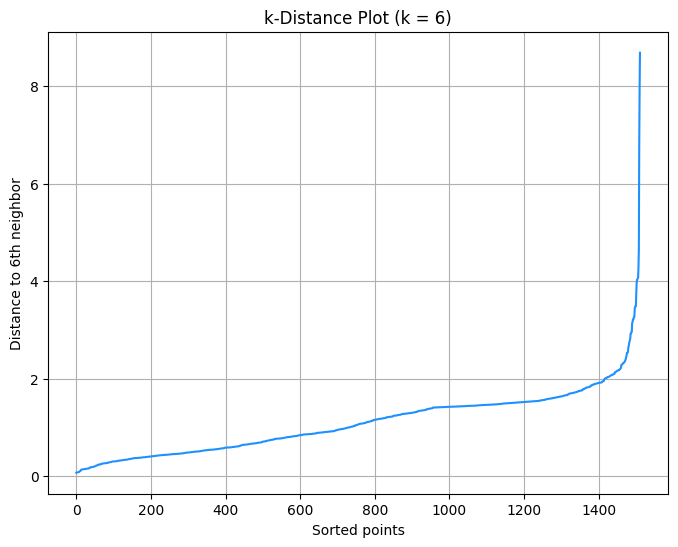

In [106]:
k_distances = plot_k_distance(data_preprocessed, minPts=7)

In [107]:
def find_optimal_eps(k_distances):
    x = range(len(k_distances))
    kneedle = KneeLocator(x, k_distances, S=1.0, curve="convex", direction="increasing")
    optimal_eps = k_distances[kneedle.knee]
    return optimal_eps

optimal_eps = find_optimal_eps(k_distances)
print("Valore suggerito di eps:", optimal_eps)

Valore suggerito di eps: 2.534046803359113


In [108]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=7)
labels = dbscan.fit_predict(data_preprocessed)
data['dbscan_labels'] = labels

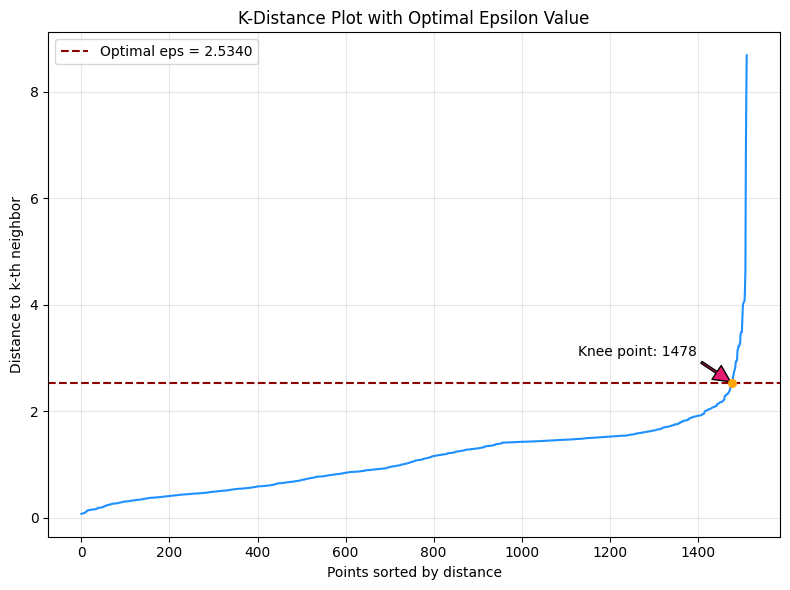

Number of clusters: 1
Number of noise points: 25 (1.65%)
Number of data points: 1512


In [109]:
# Plot k-distances with optimal eps value highlighted
plt.figure(figsize=(8, 6))
plt.plot(k_distances, color=color_blue_light)
plt.axhline(y=optimal_eps, color=color_red, linestyle='--', 
           label=f'Optimal eps = {optimal_eps:.4f}')

# Add a circle at the knee point
knee_idx = np.where(k_distances >= optimal_eps)[0][0]
plt.scatter(knee_idx, optimal_eps, color=color_orange, s=30, zorder=5)

plt.title('K-Distance Plot with Optimal Epsilon Value')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to k-th neighbor')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text annotation for the knee point
plt.annotate(f'Knee point: {knee_idx}', 
             xy=(knee_idx, optimal_eps),
             xytext=(knee_idx-350, optimal_eps+0.5),
             arrowprops=dict(facecolor=color_pink, shrink=0.05, width=1.5),
             fontsize=10)

plt.tight_layout()
plt.show()

# Print statistics about clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(labels)*100:.2f}%)")
print(f"Number of data points: {len(labels)}")

In [110]:
optimal_eps = 1.45
dbscan = DBSCAN(eps=optimal_eps, min_samples=7)
labels = dbscan.fit_predict(data_preprocessed)
data['dbscan_labels'] = labels

# Print statistics about clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(labels)*100:.2f}%)")
print(f"Number of data points: {len(labels)}")

Number of clusters: 6
Number of noise points: 324 (21.43%)
Number of data points: 1512


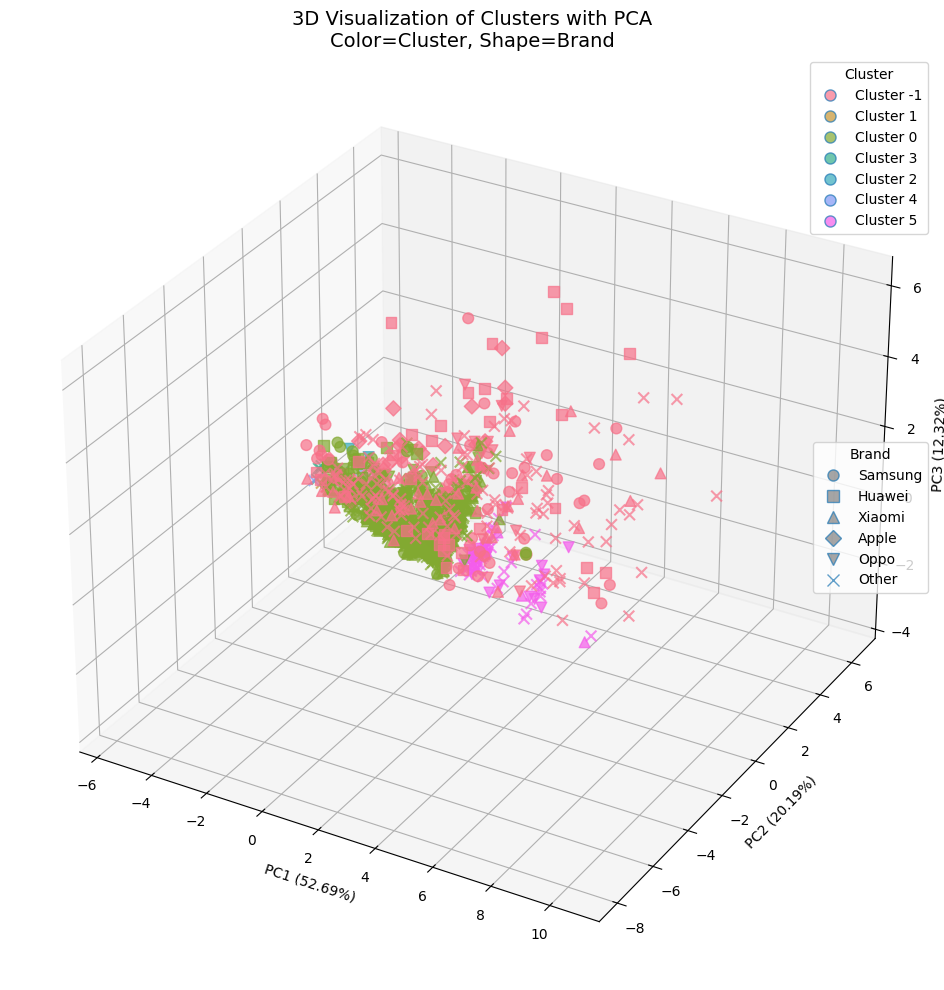


Variance explained by principal components:
PC1: 52.69%
PC2: 20.19%
PC3: 12.32%

Characteristics of principal components:
     price(USD)   battery  weight(g)  storage(GB)   ram(GB)    inches
PC1    0.213193  0.388835   0.446937     0.411522  0.428533  0.500612
PC2    0.622148 -0.481473  -0.262449     0.404907  0.297651 -0.244314
PC3    0.682103 -0.005497   0.372602    -0.393474 -0.477675  0.113484


In [111]:
# Select only the numeric columns for PCA
numeric_cols = ['price(USD)', 'battery', 'weight(g)', 'storage(GB)', 'ram(GB)', 'inches']
data_numeric = df[numeric_cols].dropna()

# Standardization
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data=principal_components, 
                      columns=['PC1', 'PC2', 'PC3'])

# Add cluster information from the data DataFrame 
# (matching indices with data_numeric)
pca_df['Cluster'] = data.loc[data_numeric.index, 'dbscan_labels']
pca_df['Brand'] = df.loc[data_numeric.index, 'brand']

# Prepare shape maps for brands
# Select the top 5 most frequent brands to simplify visualization
top_brands = pca_df['Brand'].value_counts().nlargest(5).index.tolist()

# Create shapes dictionary (excluding less frequent brands)
marker_map = {
    'Samsung': 'o',
    'Huawei': 's',
    'Xiaomi': '^',
    'Apple': 'D',
    'Oppo': 'v',
    'Other': 'x'  # For all other brands
}

pca_df['Marker'] = pca_df['Brand'].apply(lambda x: marker_map[x] if x in marker_map else marker_map['Other'])

# Create 3D plot
plt.figure(figsize=(12, 10))
ax = plt.axes(projection='3d')

# Color palette for clusters
unique_clusters = pca_df['Cluster'].unique()
palette = sns.color_palette("husl", n_colors=len(unique_clusters))
cluster_color_map = dict(zip(unique_clusters, palette))

# Plot for each cluster-marker combination
for cluster in unique_clusters:
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    
    for marker_type in cluster_data['Marker'].unique():
        subset = cluster_data[cluster_data['Marker'] == marker_type]
        if not subset.empty:
            brand_name = subset['Brand'].iloc[0] if marker_type != 'x' else 'Other'
            ax.scatter(subset['PC1'], 
                      subset['PC2'], 
                      subset['PC3'],
                      c=[cluster_color_map[cluster]], # Use cluster color from map
                      marker=marker_type,
                      s=60,
                      alpha=0.7,
                      label=f'Cluster {cluster}, {brand_name}')

# Add custom legend
handles = []
for cluster in unique_clusters:
    handles.append(plt.Line2D([0], [0], linestyle="none", 
                           marker="o", alpha=0.7, markersize=8,
                           markerfacecolor=cluster_color_map[cluster], 
                           label=f'Cluster {cluster}'))
    
brand_shapes = [plt.Line2D([0], [0], linestyle="none", 
               marker=marker, alpha=0.7, markersize=8,
               markerfacecolor='gray', label=brand) 
              for brand, marker in marker_map.items()]

first_legend = ax.legend(handles=handles, title='Cluster', loc='upper right')
ax.add_artist(first_legend)
ax.legend(handles=brand_shapes, title='Brand', loc='center right')

ax.set_xlabel('PC1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('PC2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
ax.set_zlabel('PC3 (%.2f%%)' % (pca.explained_variance_ratio_[2]*100))
ax.set_title('3D Visualization of Clusters with PCA\nColor=Cluster, Shape=Brand', fontsize=14)

plt.tight_layout()
plt.show()

# Additional information about components
print("\nVariance explained by principal components:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var*100:.2f}%")

# Show the weight of original features on PCs
print("\nCharacteristics of principal components:")
components_df = pd.DataFrame(pca.components_, columns=numeric_cols, index=['PC1', 'PC2', 'PC3'])
print(components_df)


Cluster Distribution:
dbscan_labels
-1     324
 0    1078
 1       7
 2       7
 3       7
 4       8
 5      81
Name: count, dtype: int64

Cluster Statistics:
               price(USD)                                   battery                           weight(g)                          storage(GB)                      
                     mean         std      min     max         mean         std   min   max        mean        std    min    max        mean         std  min  max
dbscan_labels                                                                                                                                                     
-1             571.424160  427.728623   70.000  2300.0  4055.870370  964.975767  1821  7250  196.086420  46.463128  130.0  500.0  136.398148  112.759005    1  512
 0             270.206048  148.247263   40.000  1040.0  4500.486085  681.385346  2200  6000  185.743970  15.345702  140.0  233.0   92.133581   40.499169    8  128
 1             111.428571

<Figure size 1400x800 with 0 Axes>

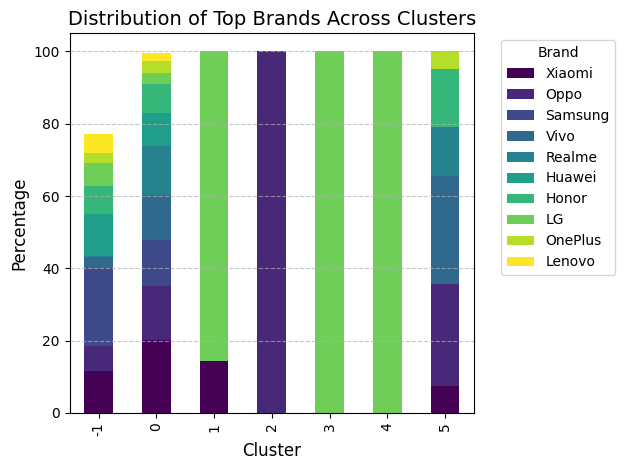

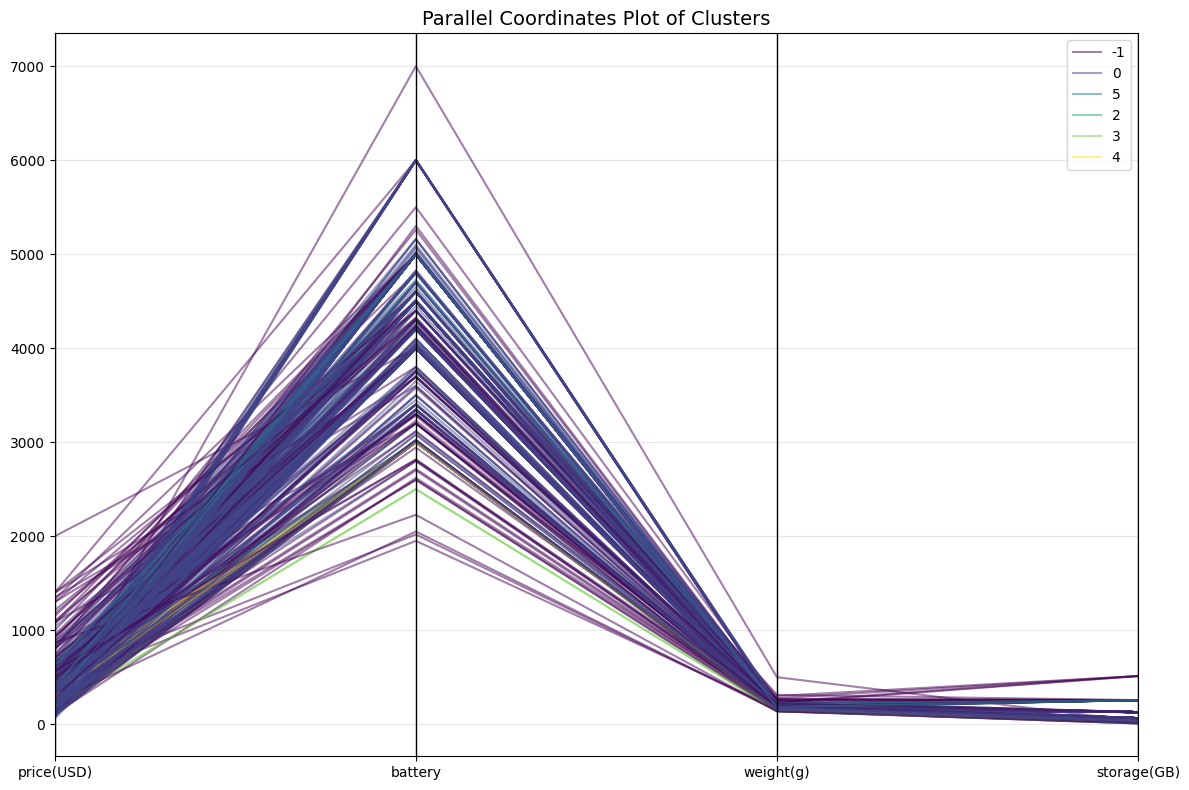

In [112]:
# Analyze the cluster results from DBSCAN
cluster_counts = data['dbscan_labels'].value_counts().sort_index()
print(f"Cluster Distribution:\n{cluster_counts}")

# Calculate statistics for each cluster
cluster_stats = data.groupby('dbscan_labels').agg({
    'price(USD)': ['mean', 'std', 'min', 'max'],
    'battery': ['mean', 'std', 'min', 'max'],
    'weight(g)': ['mean', 'std', 'min', 'max'],
    'storage(GB)': ['mean', 'std', 'min', 'max']
})

print("\nCluster Statistics:")
print(cluster_stats)

# Visualize the distribution of brands across clusters
plt.figure(figsize=(14, 8))
brand_counts = data.groupby(['dbscan_labels', 'brand']).size().unstack().fillna(0)

# Normalize to percentage within each cluster
brand_percentages = brand_counts.div(brand_counts.sum(axis=1), axis=0) * 100

# Plot only top brands for clarity
top_n_brands = 10
top_brands = data['brand'].value_counts().nlargest(top_n_brands).index

# Filter for top brands
filtered_percentages = brand_percentages[top_brands]

ax = filtered_percentages.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Top Brands Across Clusters', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create parallel coordinates plot for numerical features
plt.figure(figsize=(12, 8))

# Get a sample of data points for better visualization if dataset is large
sample_size = min(500, len(data))
sample_indices = np.random.choice(range(len(data)), sample_size, replace=False)
sample_data = data.iloc[sample_indices]

# Create parallel coordinates
pd.plotting.parallel_coordinates(
    sample_data[['price(USD)', 'battery', 'weight(g)', 'storage(GB)', 'dbscan_labels']],
    'dbscan_labels',
    colormap=plt.cm.viridis,
    alpha=0.5
)

plt.title('Parallel Coordinates Plot of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()